# **PLEASE MAKE YOUR OWN COPY OF THIS NOTEBOOK**

# CIS 5450 Homework 2.5 (Extra Credit)
**Due: Thursday, March 13th, 10:00 PM (or until 4/29 10:00 PM for 10% less extra credit)**

**Total Points: 20**

**This extra credit is completely optional!** You do not have to complete all parts to submit it.

If you want help with this extra credit, visit Jeff's office hours (Thursday 11AM - 1 PM).

Welcome to the Homework 2 extra credit! Here, you'll write more complex SQL queries with DuckDB and take advantage of more advanced SQL features. The following questions do not have as much scaffolding as the regular homeworks: you are expected to do some work figuring out how to structure the query and what SQL features to use.

There is no need to "clean" the data files. **All extra credit questions _can_ and _should_ be answered in a single SQL query!** Do **not** answer the extra credit questions using pandas dataframe manipulations!

**Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the notebook!**

# Part 0: Libraries and Set Up

In [1]:
%set_env HW_ID=cis5450_sp25_HW2.5

env: HW_ID=cis5450_sp25_HW2.5


In [2]:
%%capture
!pip install penngrader-client

In [3]:
!pip install pandas
!pip install duckdb
!pip install pandasql
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=ede6967281028ae381389465067def9744c2b7df1be44ad12940e2df9f0795e4
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [4]:
from penngrader.grader import *
import os
import pandas as pd
import pandasql as ps
import duckdb
from matplotlib import pyplot as plt

In [5]:
# Download the datasets
!wget -nc -O hw25data.tar.xz https://www.dropbox.com/scl/fi/9jeh06gktxvo2fosb5vb6/hw25data.tar.xz?rlkey=04zq1e1hoae1c6nj5ag79pbmb&st=esby9tg1
!tar xfJ hw25data.tar.xz

--2025-04-30 23:41:47--  https://www.dropbox.com/scl/fi/9jeh06gktxvo2fosb5vb6/hw25data.tar.xz?rlkey=04zq1e1hoae1c6nj5ag79pbmb
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45caa40e28beb7ab2b9bf36343.dl.dropboxusercontent.com/cd/0/inline/Co0U-u199jxxmcBJv6a0mEfI7B3r9FCBFs3-SA54kMXxZVQgDkoCsAZuJRf15AI9HwxVWWhUXKEJEblFJvisL31mQMnbThXv0LLa3Tg-alwTulFkxslPcPIrBusvNUmWbx8/file# [following]
--2025-04-30 23:41:47--  https://uc45caa40e28beb7ab2b9bf36343.dl.dropboxusercontent.com/cd/0/inline/Co0U-u199jxxmcBJv6a0mEfI7B3r9FCBFs3-SA54kMXxZVQgDkoCsAZuJRf15AI9HwxVWWhUXKEJEblFJvisL31mQMnbThXv0LLa3Tg-alwTulFkxslPcPIrBusvNUmWbx8/file
Resolving uc45caa40e28beb7ab2b9bf36343.dl.dropboxusercontent.com (uc45caa40e28beb7ab2b9bf36343.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:601c:15::a27d:60f
Connecting to uc45

## PennGrader Setup

In [6]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND
# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 73619426

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = "...watching silo on appletv...."

Leave this cell as-is...

In [7]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [16]:
grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 73619426

Make sure this correct or we will not be able to store your grade


# Part 1: Car Prices (4 Points)

When buying a used car, you’d like for that car to be some reasonable trade off of new (as in years since it was made), low-mileage, and cheap. What you *don’t* want to do is buy a used car that’s strictly worse than some other car on the market.

For example, you would not want to buy a 2020 Honda Accord with 50,000 miles on it for \$20,000 if another 2020 Honda Accord with 50,000 miles is available for \$18,000. However, you would be okay buying a 2022 Honda Accord with 50,000 miles for \$20,000 because it’s newer than the others. You don’t have a preference between year, mileage, and price, you just want to filter out all of the cars that are "bad deals". You also don't care to make comparisons between Brand/Model of car.

| Brand | Model  | Year | Mileage | Price | Worth considering? |
| ----- | ------ | ---- | ------- | ----- | ------------------ |
| Honda | Accord | 2020 | 50000   | 20000 | ❌                 |
| Honda | Accord | 2020 | 50000   | 18000 | ✅                 |
| Honda | Accord | 2022 | 50000   | 20000 | ✅                 |
| Honda | Accord | 2020 | 40000   | 22000 | ✅                 |

Write a single SQL query that finds all such cars that are "worth considering" for which there are no cars of the same brand and model that are strictly better deals in terms of year, mileage, or price. Then, use this query to return the count of such cars per brand, model pair. Intuitively, not all of the cars out there are good deals, so these counts should be smaller than the total number of cars for sale in each brand,  model pair.

In [8]:
# Load the data (10,000 used cars for sale)
car_df = pd.read_csv("car_prices.csv")
car_df

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084


Write your solution below as a single SQL query. You may find it useful to work with smaller queries first, and build them up into the final query using CTEs. The resulting dataframe should have 3 columns: `brand`, `model`, `num_deals`. Order of `car_answer_df` doesn't matter as long as all of the car brand/model pairs are present.

Hints:
* You should learn about [subqueries](https://duckdb.org/docs/sql/expressions/subqueries.html#not-exists)


In [9]:
duckdb.register('cars', car_df)

In [10]:
car_answer_df = duckdb.sql("""
WITH valid_deals AS (
  SELECT c1.*
  FROM cars c1
  WHERE NOT EXISTS (
    SELECT 1
    FROM cars c2
    WHERE c1.Brand = c2.Brand
      AND c1.Model = c2.Model
      AND (
        (c2.Year > c1.Year AND c2.Mileage <= c1.Mileage AND c2.Price <= c1.Price) OR
        (c2.Year >= c1.Year AND c2.Mileage < c1.Mileage AND c2.Price <= c1.Price) OR
        (c2.Year >= c1.Year AND c2.Mileage <= c1.Mileage AND c2.Price < c1.Price)
      )
  )
)
SELECT Brand, Model, COUNT(*) AS num_deals
FROM valid_deals
GROUP BY Brand, Model
""").df()

In [17]:
# 4 points
grader.grade(test_case_id = 'test_car_prices', answer = car_answer_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 2: Stock Prices (8 Points)

Here, we have some stock price data for a single stock ticker (i.e., a single company). When we're looking at a chart of historical prices for a stock, one feature of interest are the "peaks" and "troughs" in the plot of price vs. time.

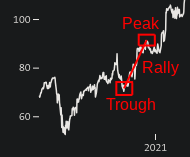

Our definition of "trough" and "peak" may vary depending on the analysis that we do. A very simple definition would be that a trough occurs any time both the preceding and following prices are higher and that a peak occurs any time both the preceding and following prices are lower.

In this question, we'll define a peak to be any time there is no higher price in the _surrounding 14 days_ (inclusive), and that similarly, a trough is any time there is no lower price in the surrounding 14 days.

The dataset contains multiple price columns per-day. **We'll use the "Close" price as the price for the day.**

In [11]:
stock_df = pd.read_csv("stock_prices.csv")
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02 00:00:00+00:00,68.186821,68.433998,68.433998,67.324501,67.420502,27278000
1,2020-01-03 00:00:00+00:00,67.830101,68.075996,68.687500,67.365997,67.400002,23408000
2,2020-01-06 00:00:00+00:00,69.638054,69.890503,69.916000,67.550003,67.581497,46768000
3,2020-01-07 00:00:00+00:00,69.503548,69.755501,70.175003,69.578003,70.023003,34330000
4,2020-01-08 00:00:00+00:00,69.998253,70.251999,70.592499,69.631500,69.740997,35314000
...,...,...,...,...,...,...,...
1253,2024-12-24 00:00:00+00:00,196.110001,196.110001,196.110001,193.779999,194.839996,10403300
1254,2024-12-26 00:00:00+00:00,195.600006,195.600006,196.750000,194.380005,195.149994,12046600
1255,2024-12-27 00:00:00+00:00,192.759995,192.759995,195.320007,190.649994,194.949997,18891400
1256,2024-12-30 00:00:00+00:00,191.240005,191.240005,192.550003,189.119995,189.800003,14264700


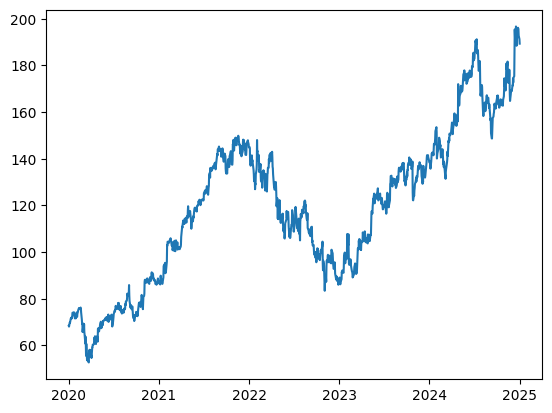

In [12]:
plt.plot(stock_df["Date"], stock_df["Close"])

One thing to note about the above dataframe is that there are days missing! We do not have a stock price for every single consecutive day: there are holes where we have no price for a given day. You'll need to account for this in the query that you write.

Once we have the peaks and troughs, we might be interested in pairing troughs and peaks that occur consecutively, giving us the length of each "rally" in the stock. For each peak, find the immediately preceding trough. It's possible that there might be multiple peaks corresponding to the same trough, so you should take only the latest (newest date) peak corresponding to a particular trough.

Write a single query that returns the trough and peak for each rally in the stock price over time. The resulting dataframe should have 4 columns: `trough_date`, `trough_price`, `peak_date`, `peak_price`. Order of rows in `stock_answer_df` doesn't matter.

Hints:
* You probably need to use [subqueries](https://duckdb.org/docs/sql/expressions/subqueries.html)
* You may want to investigate [lateral joins](https://duckdb.org/docs/sql/query_syntax/from.html#lateral-joins)
* You may find the [RANK window function](https://duckdb.org/docs/sql/functions/window_functions.html) helpful
* You may find it helpful to create debug visualizations with matplotlib (though no visualizations are required for credit)

In [23]:
stock_answer_df = duckdb.sql("""
-- KEEP THIS LINE
SET TIMEZONE='UTC';
-- Write the rest of your query below
WITH stock_data AS (
    SELECT
        Date,
        Close,
        ROW_NUMBER() OVER (ORDER BY Date) AS rn
    FROM stock_df
),
peaks AS (
    SELECT
        Date AS peak_date,
        Close AS peak_price
    FROM stock_data sd1
    WHERE Close = (
        SELECT MAX(Close)
        FROM stock_data sd2
        WHERE sd2.rn BETWEEN sd1.rn - 14 AND sd1.rn + 14
    )
),
troughs AS (
    SELECT
        Date AS trough_date,
        Close AS trough_price
    FROM stock_data sd1
    WHERE Close = (
        SELECT MIN(Close)
        FROM stock_data sd2
        WHERE sd2.rn BETWEEN sd1.rn - 14 AND sd1.rn + 14
    )
),
paired_data AS (
    SELECT
        troughs.trough_date,
        troughs.trough_price,
        peaks.peak_date,
        peaks.peak_price,
        RANK() OVER (PARTITION BY troughs.trough_date ORDER BY peaks.peak_date DESC) AS rank
    FROM troughs
    JOIN peaks ON peaks.peak_date > troughs.trough_date
)
SELECT
    trough_date,
    trough_price,
    peak_date,
    peak_price
FROM paired_data
WHERE rank = 1
ORDER BY trough_date;


""").df()
stock_answer_df

,trough_date,trough_price,peak_date,peak_price
0,2020-01-03 00:00:00+00:00,68.075996,2024-12-16 00:00:00+00:00,196.660004
1,2020-03-23 00:00:00+00:00,52.706501,2024-12-16 00:00:00+00:00,196.660004
2,2020-06-26 00:00:00+00:00,68.126999,2024-12-16 00:00:00+00:00,196.660004
3,2020-08-04 00:00:00+00:00,73.665001,2024-12-16 00:00:00+00:00,196.660004
4,2020-09-23 00:00:00+00:00,70.469498,2024-12-16 00:00:00+00:00,196.660004
5,2020-12-22 00:00:00+00:00,86.011002,2024-12-16 00:00:00+00:00,196.660004
6,2021-03-08 00:00:00+00:00,100.375000,2024-12-16 00:00:00+00:00,196.660004
7,2021-05-12 00:00:00+00:00,110.012497,2024-12-16 00:00:00+00:00,196.660004
8,2021-10-04 00:00:00+00:00,133.659500,2024-12-16 00:00:00+00:00,196.660004
9,2021-12-01 00:00:00+00:00,141.051498,2024-12-16 00:00:00+00:00,196.660004


In [13]:
stock_answer_df = duckdb.sql("""
-- KEEP THIS LINE
SET TIMEZONE='UTC';
-- Write the rest of your query below
WITH prices AS (
  SELECT
    Date::DATE AS date,
    Close
  FROM stock_df
),

-- Identify all troughs where the Close price is the minimum in a ±14-day window
troughs AS (
  SELECT p1.date AS trough_date, p1.Close AS trough_price
  FROM prices p1
  WHERE NOT EXISTS (
    SELECT 1 FROM prices p2
    WHERE p2.date BETWEEN p1.date - INTERVAL '14 days' AND p1.date + INTERVAL '14 days'
      AND p2.Close < p1.Close
  )
),

-- Identify all peaks where the Close price is the maximum in a ±14-day window
peaks AS (
  SELECT p1.date AS peak_date, p1.Close AS peak_price
  FROM prices p1
  WHERE NOT EXISTS (
    SELECT 1 FROM prices p2
    WHERE p2.date BETWEEN p1.date - INTERVAL '14 days' AND p1.date + INTERVAL '14 days'
      AND p2.Close > p1.Close
  )
),

-- Pair the peaks with the most recent troughs (one-to-one matching)
peak_trough_pairs AS (
  SELECT
    t.trough_date,
    t.trough_price,
    p.peak_date,
    p.peak_price,
    ROW_NUMBER() OVER (PARTITION BY t.trough_date ORDER BY p.peak_date) AS peak_rank
  FROM troughs t
  JOIN peaks p
    ON p.peak_date > t.trough_date
)

-- Only keep the latest peak for each trough, and ensure proper pairing
SELECT
  trough_date,
  trough_price,
  peak_date,
  peak_price
FROM peak_trough_pairs
WHERE peak_rank = 1
ORDER BY trough_date;
""").df()
stock_answer_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,trough_date,trough_price,peak_date,peak_price
0,2020-01-03,68.075996,2020-01-23,74.234497
1,2020-03-23,52.706501,2020-06-10,73.235001
2,2020-06-11,70.095001,2020-07-22,78.242500
3,2020-06-26,68.126999,2020-07-22,78.242500
4,2020-08-04,73.665001,2020-09-02,85.869499
5,2020-09-23,70.469498,2020-12-02,91.248497
6,2020-10-28,75.540001,2020-12-02,91.248497
7,2020-11-23,86.377998,2020-12-02,91.248497
8,2020-12-22,86.011002,2021-02-17,105.931000
9,2021-01-06,86.143997,2021-02-17,105.931000


In [14]:
con = duckdb.connect()
con.register("stock_df", stock_df)

# SQL Query to extract trough-peak pairs
query = """
WITH peaks AS (
    SELECT
        s1.Date AS peak_date,
        s1.Close AS peak_price
    FROM stock_df s1
    WHERE s1.Close = (
        SELECT MAX(s2.Close)
        FROM stock_df s2
        WHERE s2.Date BETWEEN s1.Date - INTERVAL 14 DAY AND s1.Date + INTERVAL 14 DAY
    )
),
troughs AS (
    SELECT
        s1.Date AS trough_date,
        s1.Close AS trough_price
    FROM stock_df s1
    WHERE s1.Close = (
        SELECT MIN(s2.Close)
        FROM stock_df s2
        WHERE s2.Date BETWEEN s1.Date - INTERVAL 14 DAY AND s1.Date + INTERVAL 14 DAY
    )
),
trough_peak_pairs AS (
    SELECT
        t.trough_date,
        t.trough_price,
        p.peak_date,
        p.peak_price,
        RANK() OVER (
            PARTITION BY t.trough_date
            ORDER BY p.peak_date DESC
        ) AS peak_rank
    FROM troughs t
    JOIN peaks p
    ON p.peak_date > t.trough_date
)
SELECT
    trough_date,
    trough_price,
    peak_date,
    peak_price
FROM trough_peak_pairs
WHERE peak_rank = 1
ORDER BY trough_date;
"""

# Execute the query
stock_answer_df = con.execute(query).df()

# Confirm output
print(len(stock_answer_df))  # Should be 32
stock_answer_df.head()

38


,trough_date,trough_price,peak_date,peak_price
0,2020-01-03 00:00:00+00:00,68.075996,2024-12-16 00:00:00+00:00,196.660004
1,2020-03-23 00:00:00+00:00,52.706501,2024-12-16 00:00:00+00:00,196.660004
2,2020-06-11 00:00:00+00:00,70.095001,2024-12-16 00:00:00+00:00,196.660004
3,2020-06-26 00:00:00+00:00,68.126999,2024-12-16 00:00:00+00:00,196.660004
4,2020-08-04 00:00:00+00:00,73.665001,2024-12-16 00:00:00+00:00,196.660004


In [22]:
# 8 points
grader.grade(test_case_id = 'test_stock_prices', answer = stock_answer_df)

You earned 0/8 points.

Your answer does not have the right number of trough, peak pairs. There should be 32 pairs. Don't worry, you can re-submit and we will keep only your latest score.


# Part 3: Chess Streaks (8 Points)

Here, we have data from lichess.org, an online platform for playing chess. The table records data about 20,000 chess games played on the platform, including when they were played, the players' usernames, and who won.

We would like to calculate the players who had the longest winning and losing streaks. A streak is defined as a consecutive run of wins (or a consecutive run of losses). Ignore draws (e.g., if a player's 6 game history was Win, Win, Draw, Win, Win, Loss, that player's win streak was length 4).

In [10]:
chess_df = pd.read_csv("chess.csv")
chess_df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


Write a single query that calculates the players with the top 10 longest streaks. The answer dataframe should contain exactly 10 rows (a mix of win and loss streaks). The dataframe should have 3 columns: `player_id`, `streak_type`, and `streak_length`. `streak_type` should be "winner" or "loser". Order of the rows in `chess_answer_df` doesn't matter.

Hints:
* You may want to compose several [CTEs](https://duckdb.org/docs/sql/query_syntax/with.html) to break the problem into smaller pieces
* You may want to learn about [UNION](https://duckdb.org/docs/sql/query_syntax/setops.html#union)
* Window functions may be helpful, especially [ROW_NUMBER](https://duckdb.org/docs/sql/functions/window_functions.html#row_numberorder-by-ordering) and [LAG](https://duckdb.org/docs/sql/functions/window_functions.html#lagexpr-offset-default-order-by-ordering-ignore-nulls)

In [13]:
chess_answer_df = duckdb.sql("""
WITH base AS (
    SELECT
        created_at,
        white_id AS player_id,
        CASE
            WHEN winner = 'white' THEN 'Win'
            WHEN winner = 'black' THEN 'Loss'
            ELSE 'Draw'
        END AS result
    FROM chess_df
    UNION ALL
    SELECT
        created_at,
        black_id AS player_id,
        CASE
            WHEN winner = 'black' THEN 'Win'
            WHEN winner = 'white' THEN 'Loss'
            ELSE 'Draw'
        END AS result
    FROM chess_df
),
filtered AS (
    SELECT * FROM base WHERE result IN ('Win', 'Loss')
),
with_seq AS (
    SELECT
        player_id,
        result,
        created_at,
        ROW_NUMBER() OVER (PARTITION BY player_id ORDER BY created_at) AS game_seq,
        LAG(result) OVER (PARTITION BY player_id ORDER BY created_at) AS prev_result
    FROM filtered
),
flags AS (
    SELECT
        *,
        CASE
            WHEN result = prev_result THEN 0
            ELSE 1
        END AS streak_start
    FROM with_seq
),
grouped AS (
    SELECT
        player_id,
        result,
        SUM(streak_start) OVER (PARTITION BY player_id ORDER BY game_seq) AS streak_group
    FROM flags
),
streaks AS (
    SELECT
        player_id,
        result,
        streak_group,
        COUNT(*) AS streak_length
    FROM grouped
    GROUP BY player_id, result, streak_group
),
longest_per_player AS (
    SELECT
        player_id,
        CASE WHEN result = 'Win' THEN 'winner' ELSE 'loser' END AS streak_type,
        MAX(streak_length) AS streak_length
    FROM streaks
    GROUP BY player_id, result
),
top10 AS (
    SELECT * FROM longest_per_player
    ORDER BY streak_length DESC
    LIMIT 10
)
SELECT * FROM top10;
""").df()
chess_answer_df

,player_id,streak_type,streak_length
0,chesscarl,winner,42
1,doraemon61,winner,38
2,thebestofthebad,loser,34
3,smilsydov,winner,31
4,projetoxadrez,winner,29
5,siindbad,winner,26
6,laode_syahril,winner,26
7,lukarpov,loser,24
8,lzchips,winner,24
9,chesswithmom,winner,24


In [14]:
# 8 points
grader.grade(test_case_id = 'test_chess_streaks', answer = chess_answer_df)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):

1. Restart and Run-All to make sure there's nothing wrong with your notebook
2. Double check that you have the correct PennID (all numbers) in the autograder.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and download both the .ipynb and .py files, renaming them as "homework2.ipynb" and "homework2.py" respectively. Upload both files to Gradescope directly!
5. Check your .ipynb file is visible under the code tab. If there is a "large file error" go back and delete all occurances of printing an entire df, and/or make your figure sizes smaller, then resubmit. Then confirm the notebook preview is now visible in your Gradescope submission.

You MUST verify that the autograder finishes running and gives you your expected score (not a 0).

Please contact Jeff (jefftao@seas.upenn.edu, OH Thursday 11 AM - 1 PM) if you have any issues submitting, but otherwise best of luck! Congrats on finishing the HW.